# P2. Classification on the Walmart Dataset

Task: load the Walmart dataset, write a Support Vector Machine to perform classification over the Month or Season (S1:JAN-FEB-MAR, S2:APR,MAY,JUN, S3:JUL,AUG,SEP, S4:OCT,NOV,DEC) in which a purchase was made, test the network and plot the results for each class.
<!-- ![Walmart](https://raw.githubusercontent.com/Masterx-AI/Project_Retail_Analysis_with_Walmart/main/Wallmart1.jpg) -->


## Task 0: Import libraries ✅

In [7]:
!pip install numpy matplotlib pandas seaborn scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [8]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set_theme()
%matplotlib inline

## Task 1: Download/Import Dataset 📃

Link: https://www.kaggle.com/datasets/yasserh/walmart-dataset/input

In [110]:
import os
# Make sure to upload the data in colab
# Importing our dataset
df = pd.read_csv("Walmart.csv")
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## Task 2: Exploring the data 📃

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [11]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

## Task 3: Preparing the Data 📃
Normalization of the data

In [120]:
from sklearn.model_selection import train_test_split
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Season'] = (df['Month']-1) // 3 + 1

df_final = df
df_final = pd.get_dummies(df_final, columns=['Store'], drop_first=True)
# df_final = pd.get_dummies(df_final, columns=['Year'], drop_first=True)
df_final = df_final.drop(columns=['Date', 'Season', 'Month', 'Year'])

df_train, df_test, months_train, months_test, seasons_train, seasons_test = train_test_split(df_final, df['Month'], df['Season'], test_size=0.25, random_state=42)

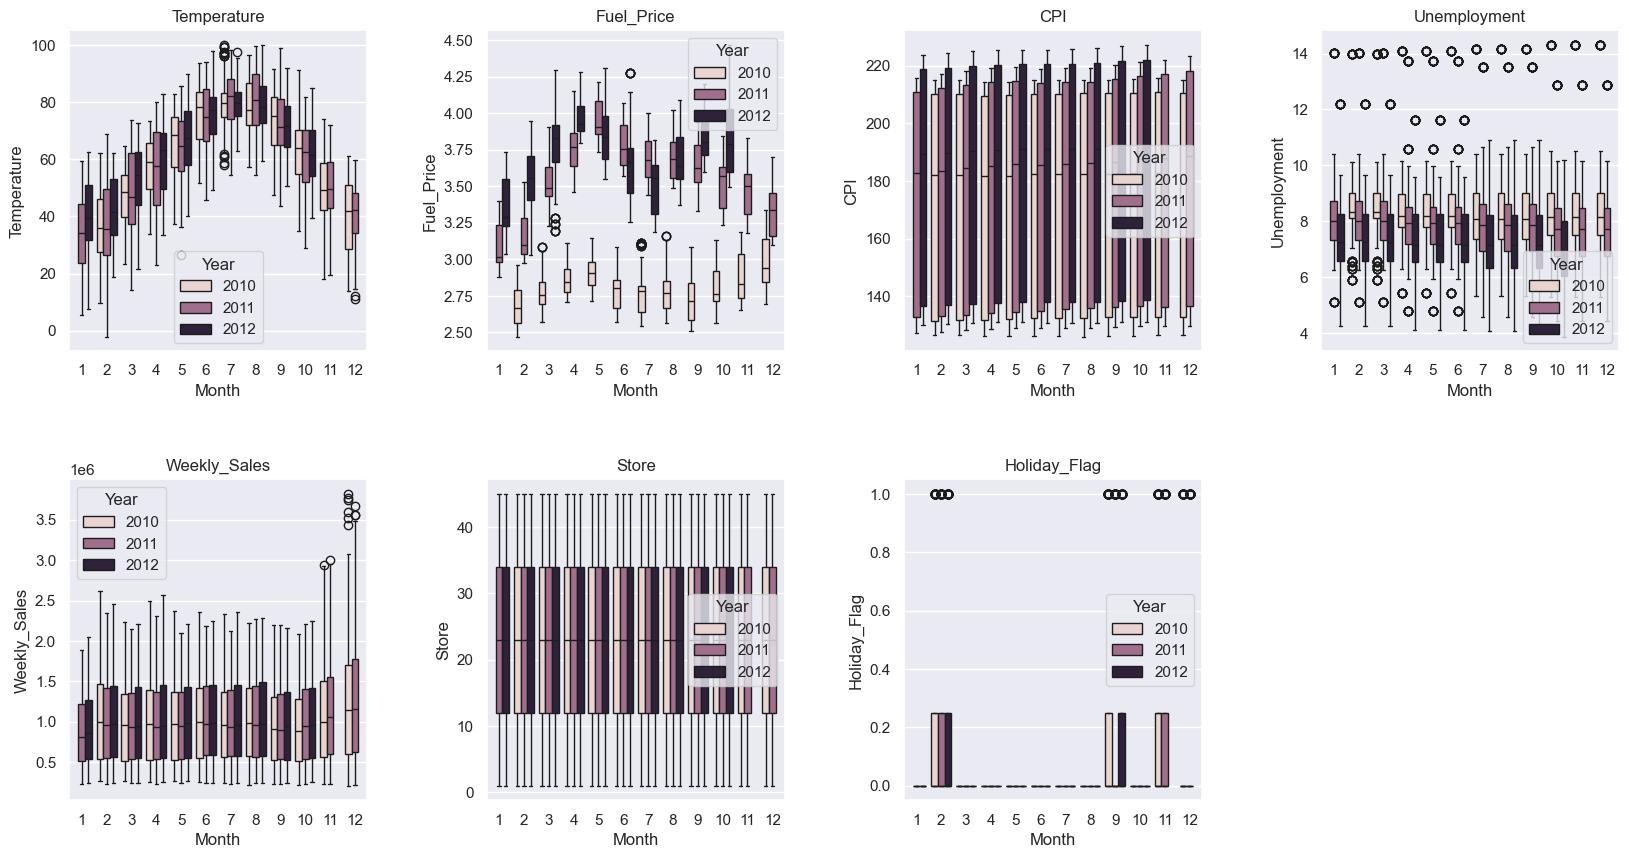

In [127]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales', 'Store', 'Holiday_Flag']):
  sns.boxplot(x='Month', y=column, hue='Year', data=df, ax=axs[i])
  axs[i].set_title(f'{column}')
  axs[i].set_xlabel('Month')
  axs[i].set_ylabel(column)

fig.delaxes(axs[-1])
plt.show()

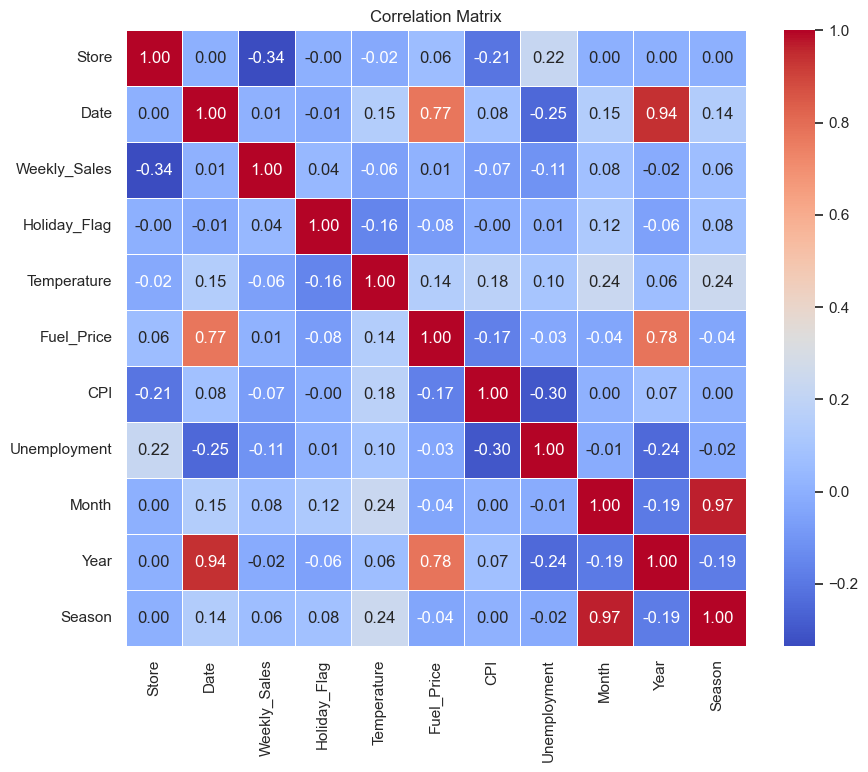

In [79]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [74]:
random_indices = np.random.choice(df_train.index, size=5, replace=False)
print(df_train.loc[random_indices])
print(months_train.loc[random_indices])
print(seasons_train.loc[random_indices])

      Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
2061     15     527389.28             0        32.63       3.789  133.958742   
2665     19    1480289.64             0        44.97       3.738  136.475129   
1087      8     809049.37             0        72.20       3.355  220.132918   
4758     34     972292.31             0        52.43       2.699  126.491290   
2768     20    1761506.68             0        23.21       3.237  205.389495   

      Unemployment  Month  Year  
2061         7.771      3  2011  
2665         7.866     11  2011  
1087         6.425      9  2011  
4758        10.210     11  2010  
2768         7.343      1  2011  
2061     3
2665    11
1087     9
4758    11
2768     1
Name: Month, dtype: int32
2061    1
2665    4
1087    3
4758    4
2768    1
Name: Season, dtype: int32


## Task 3: Define the SVM 📃

In [122]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
  StandardScaler(),
  SVC(kernel='rbf', class_weight='balanced')
)
param_grid = {'svc__C': [0.1, 1, 100, 1000, 100000],
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 3)

## Task 4: Train 📃

In [123]:
grid.fit(df_train, seasons_train)
model = grid.best_estimator_
print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.567 total time=   0.8s
[CV 2/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.482 total time=   0.8s
[CV 3/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.533 total time=   0.8s
[CV 4/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.499 total time=   0.8s
[CV 5/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.519 total time=   0.8s
[CV 1/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.399 total time=   0.8s
[CV 2/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.395 total time=   0.8s
[CV 3/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.427 total time=   0.8s
[CV 4/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.403 total time=   0.8s
[CV 5/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.420 total time=   0.8s
[CV 1/5] END .......svc__C=0.1, svc__gamma=0.01;, score=0.533 total time=   0.7s
[CV 2/5] END .......svc__C=0.1, svc__gamma=0.01

## Task 6: Show results and compare different values of C 📃

              precision    recall  f1-score   support

           1       0.69      0.79      0.74       354
           2       0.79      0.74      0.77       446
           3       0.84      0.89      0.86       454
           4       0.76      0.66      0.71       355

    accuracy                           0.78      1609
   macro avg       0.77      0.77      0.77      1609
weighted avg       0.78      0.78      0.77      1609



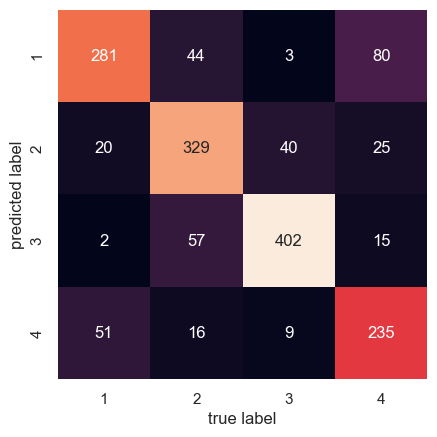

In [124]:
from sklearn.metrics import confusion_matrix
df_fit = model.predict(df_test)
mat = confusion_matrix(seasons_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(seasons_test),
            yticklabels=np.unique(seasons_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(seasons_test, df_fit))

### Train for the months

In [125]:
grid.fit(df_train, months_train)
model = grid.best_estimator_
print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.122 total time=   1.0s
[CV 2/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.060 total time=   0.9s
[CV 3/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.055 total time=   0.9s
[CV 4/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.088 total time=   0.9s
[CV 5/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.136 total time=   0.9s
[CV 1/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.112 total time=   0.9s
[CV 2/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.059 total time=   1.0s
[CV 3/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.063 total time=   0.9s
[CV 4/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.087 total time=   0.9s
[CV 5/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.121 total time=   0.9s
[CV 1/5] END .......svc__C=0.1, svc__gamma=0.01;, score=0.171 total time=   1.0s
[CV 2/5] END .......svc__C=0.1, svc__gamma=0.01

              precision    recall  f1-score   support

           1       0.81      0.85      0.83        89
           2       0.49      0.61      0.54       130
           3       0.49      0.56      0.52       135
           4       0.54      0.53      0.53       154
           5       0.39      0.42      0.40       133
           6       0.53      0.52      0.53       159
           7       0.58      0.65      0.62       162
           8       0.50      0.48      0.49       147
           9       0.66      0.57      0.61       145
          10       0.67      0.59      0.63       148
          11       0.59      0.45      0.51        97
          12       0.73      0.63      0.67       110

    accuracy                           0.57      1609
   macro avg       0.58      0.57      0.57      1609
weighted avg       0.57      0.57      0.57      1609



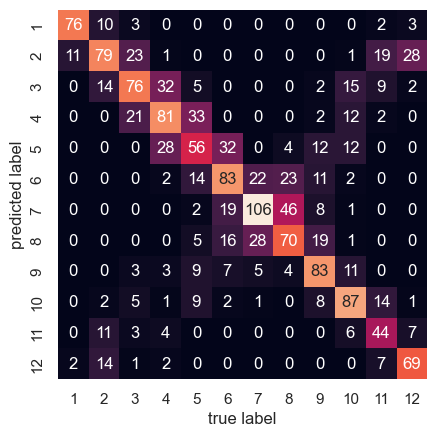

In [126]:
from sklearn.metrics import confusion_matrix
df_fit = model.predict(df_test)
mat = confusion_matrix(months_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(months_test),
            yticklabels=np.unique(months_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(months_test, df_fit))

### Try adding PCA to the model and see if it improves the results

In [179]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'pca__n_components': [1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)

In [ ]:
grid.fit(df_train, seasons_train)
model = grid.best_estimator_

# Print the best parameters
print(grid.best_params_)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.255 total time=   0.4s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.267 total time=   0.4s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.277 total time=   0.4s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.272 total time=   0.5s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.274 total time=   0.4s
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.256 total time=   0.4s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.262 total time=   0.4s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.295 total time=   0.4s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.270 total time=   0.4s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.261 total time=   0.4s
[CV 1/5

{'pca__n_components': 6, 'svc__C': 100, 'svc__gamma': 1}
              precision    recall  f1-score   support

           1       0.75      0.83      0.79       354
           2       0.81      0.75      0.78       446
           3       0.84      0.89      0.86       454
           4       0.81      0.74      0.77       355

    accuracy                           0.80      1609
   macro avg       0.80      0.80      0.80      1609
weighted avg       0.80      0.80      0.80      1609



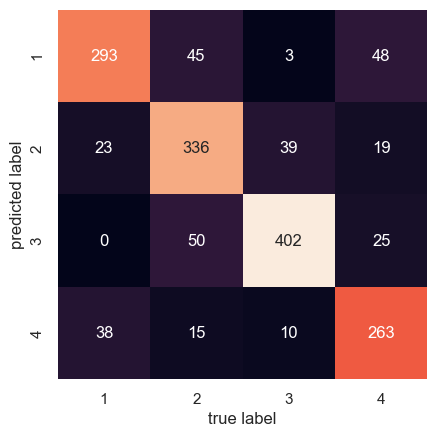

In [ ]:
from sklearn.metrics import confusion_matrix

df_fit = model.predict(df_test)
mat = confusion_matrix(seasons_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(seasons_test),
            yticklabels=np.unique(seasons_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(seasons_test, df_fit))

### Train also the months

In [186]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'pca__n_components': [1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)

In [190]:
grid.fit(df_train, months_train)
model = grid.best_estimator_

# Print the best parameters
print(grid.best_params_)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.073 total time=   0.5s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.074 total time=   0.6s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.077 total time=   0.5s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.084 total time=   0.5s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.088 total time=   0.5s
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.072 total time=   0.5s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.070 total time=   0.5s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.079 total time=   0.5s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.078 total time=   0.5s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.081 total time=   0.5s
[CV 1/5

              precision    recall  f1-score   support

           1       0.68      0.73      0.71        89
           2       0.46      0.57      0.51       130
           3       0.50      0.56      0.53       135
           4       0.51      0.46      0.48       154
           5       0.53      0.57      0.55       133
           6       0.59      0.58      0.59       159
           7       0.52      0.55      0.53       162
           8       0.47      0.48      0.47       147
           9       0.64      0.63      0.64       145
          10       0.68      0.56      0.61       148
          11       0.56      0.46      0.51        97
          12       0.58      0.54      0.56       110

    accuracy                           0.55      1609
   macro avg       0.56      0.56      0.56      1609
weighted avg       0.56      0.55      0.55      1609



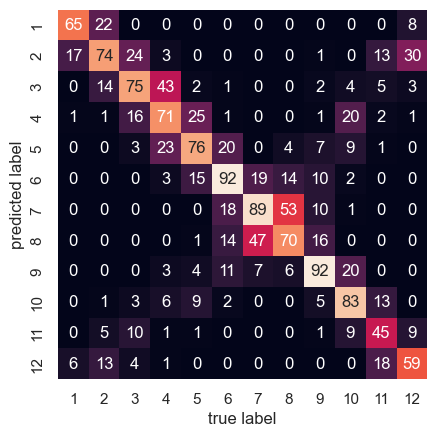

In [192]:
from sklearn.metrics import confusion_matrix

df_fit = model.predict(df_test)
mat = confusion_matrix(months_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(months_test),
            yticklabels=np.unique(months_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(months_test, df_fit))